In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math
from tqdm import tqdm
from collections import defaultdict

In [17]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)
classpath = 'd:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar'

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;

In [11]:
def generate_data(n_samples=200, n_features=50,n_informative=20, n_redundant=20, gap=0.1):
    x_raw, _ = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative
                                   , n_redundant=n_redundant, n_clusters_per_class=5, shuffle=False) #, random_state=0

    x_data, y_data, v_normal = make_separable_labels(x_raw, gap)
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33) #, random_state=42)
    return X_train, X_test, y_train, y_test

In [12]:
#Linear
def get_predicts_linear_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostLinear_v1()
    result, message, _ = clf.fit(X_train, y_train, allow_nonseparable=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    y_pred = clf.predict(X_test)
    margin = clf.get_margin()
    return y_pred, margin, separated, clf

#Ada-boost decision-stump
def get_predict_stump_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostStandardClassifier_v1(n_estimators=150)
    clf.fit(X_train, y_train, trace=True)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

#Java
def get_predicts_java_v1(X_train, X_test, y_train, y_test):
    clf = AdaBoostJavaClassifier_v1(path=classpath)
    clf.fit(X_train, y_train)
    separated = accuracy_score(y_train, clf.predict(X_train))
    margin = clf.get_margin_l1(X_train)
    y_pred = clf.predict(X_test)
    return y_pred, margin, separated, clf

In [15]:
def get_metrics(X_train, X_test, y_train, y_test):
    metrics_linear={}
    metrics_stump={}
    #Linear
    y_pred_linear, margin, separated, clf = get_predicts_linear_v1(X_train, X_test, y_train, y_test)
    metrics_linear['risk'] = 1 - accuracy_score(y_test, y_pred_linear)
    metrics_linear['precision'] = precision_score(y_test, y_pred_linear)
    metrics_linear['recall'] = recall_score(y_test, y_pred_linear)
    metrics_linear['margin'] = margin
    #Ada-boost decision-stump
    y_pred_stump, margin, separated, clf = get_predicts_java_v1(X_train, X_test, y_train, y_test)
    metrics_stump['risk'] = 1 - accuracy_score(y_test, y_pred_stump)
    metrics_stump['precision'] = precision_score(y_test, y_pred_stump)
    metrics_stump['recall'] = recall_score(y_test, y_pred_stump)
    metrics_stump['margin'] = margin
    return metrics_linear, metrics_stump

#### Varying the number of features from 25 to 500, 200 samples

In [54]:
TESTS_COUNT=3

features_numbers=[25,50,75,100,125,150,175,200,225,250,275,300]#,325,350,375,400,425,450,475,500]

marginL, marginJ, riskL, riskJ = [], [], [], []
avg_marginL, avg_marginJ, avg_riskL, avg_riskJ = [], [], [], []

for features_number in tqdm(features_numbers):
    n_features, n_informative, n_redundant= features_number, int(features_number*0.4), int(features_number*0.4) #features, 0
    buff_riskL, buff_riskJ, buff_marginL, buff_marginJ=[], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test)
        buff_riskL.append(metricsL['risk'])
        buff_riskJ.append(metricsJ['risk'])
        buff_marginL.append(metricsL['margin'])
        buff_marginJ.append(metricsJ['margin'])
        
    riskL.append(buff_riskL)
    riskJ.append(buff_riskJ)
    marginL.append(buff_marginL)
    marginJ.append(buff_marginJ)
    avg_riskL.append(sum(buff_riskL)/TESTS_COUNT)
    avg_riskJ.append(sum(buff_riskJ)/TESTS_COUNT)
    avg_marginL.append(sum(buff_marginL)/TESTS_COUNT)
    avg_marginJ.append(sum(buff_marginJ)/TESTS_COUNT)
    
marginL, marginJ, riskL, riskJ = np.array(marginL), np.array(marginJ), np.array(riskL), np.array(riskJ)


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [40:08<00:00, 200.72s/it]


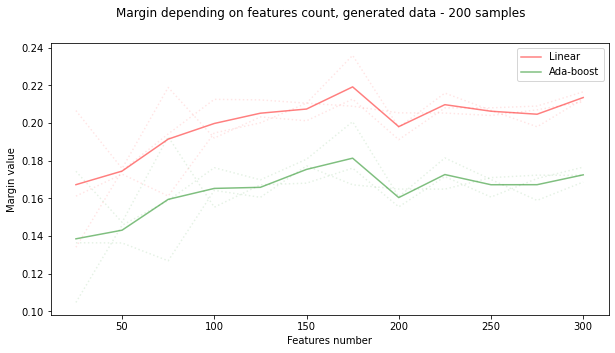

In [55]:
options = [
    ('r', 'Linear'),
    ('g', 'Ada-boost'),
]

plt.figure(figsize=(10, 5))
plt.xlabel('Features number')
plt.ylabel('Margin value')
plt.suptitle("Margin depending on features count, generated data - 200 samples")

for pos in range(TESTS_COUNT):
    plt.plot(features_list, marginL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(features_list, marginJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(features_list, avg_marginL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, avg_marginJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

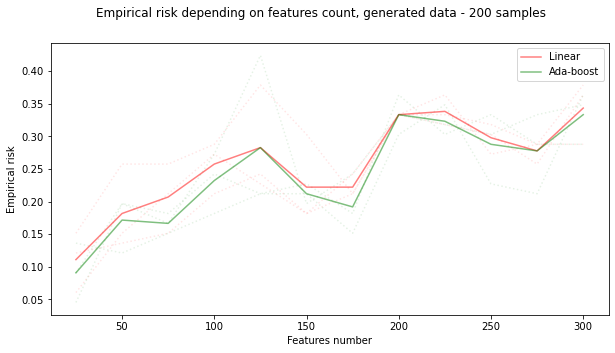

In [56]:
plt.figure(figsize=(10, 5))
plt.xlabel('Features number')
plt.ylabel('Empirical risk')
plt.suptitle("Empirical risk depending on features count, generated data - 200 samples")

for pos in range(TESTS_COUNT):
    plt.plot(features_list, riskL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(features_list, riskJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(features_list, avg_riskL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(features_list, avg_riskJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

#### Varying the number of samples from 100 to 500, 50 features

In [58]:
TESTS_COUNT=3

samples_numbers=[100,150,200,250,300,350,400,450,500]

marginL, marginJ, riskL, riskJ = [], [], [], []
avg_marginL, avg_marginJ, avg_riskL, avg_riskJ = [], [], [], []

for samples_number in tqdm(samples_numbers):
    buff_riskL, buff_riskJ, buff_marginL, buff_marginJ=[], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data(n_samples=samples_number)
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test)
        buff_riskL.append(metricsL['risk'])
        buff_riskJ.append(metricsJ['risk'])
        buff_marginL.append(metricsL['margin'])
        buff_marginJ.append(metricsJ['margin'])
        
    riskL.append(buff_riskL)
    riskJ.append(buff_riskJ)
    marginL.append(buff_marginL)
    marginJ.append(buff_marginJ)
    avg_riskL.append(sum(buff_riskL)/TESTS_COUNT)
    avg_riskJ.append(sum(buff_riskJ)/TESTS_COUNT)
    avg_marginL.append(sum(buff_marginL)/TESTS_COUNT)
    avg_marginJ.append(sum(buff_marginJ)/TESTS_COUNT)
    
marginL, marginJ, riskL, riskJ = np.array(marginL), np.array(marginJ), np.array(riskL), np.array(riskJ)


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [20:19<00:00, 135.52s/it]


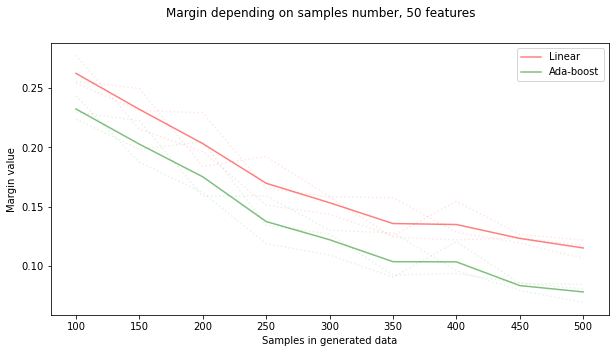

In [60]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Margin value')
plt.suptitle("Margin depending on samples number, 50 features")

for pos in range(TESTS_COUNT):
    plt.plot(samples_numbers, marginL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(samples_numbers, marginJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(samples_numbers, avg_marginL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(samples_numbers, avg_marginJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

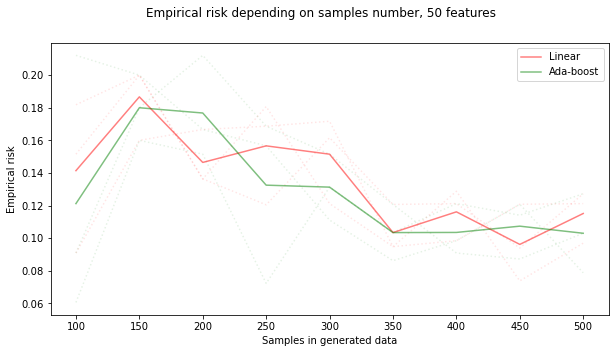

In [62]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Empirical risk')
plt.suptitle("Empirical risk depending on samples number, 50 features")

for pos in range(TESTS_COUNT):
    plt.plot(samples_numbers, riskL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(samples_numbers, riskJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(samples_numbers, avg_riskL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(samples_numbers, avg_riskJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

#### Varying the percent of informative features, 200 samples, 100 features

In [ ]:
FEATURES=100
TESTS_COUNT=3

informative_percent_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

marginL, marginJ, riskL, riskJ = [], [], [], []
avg_marginL, avg_marginJ, avg_riskL, avg_riskJ = [], [], [], []

for informative_percent in tqdm(informative_percent_list):
    n_features, n_informative, n_redundant= FEATURES, int(FEATURES*informative_percent), int(FEATURES*(0.9-informative_percent))
    buff_riskL, buff_riskJ, buff_marginL, buff_marginJ=[], [], [], []
    for _ in range(TESTS_COUNT):
        X_train, X_test, y_train, y_test = generate_data \
            (n_features=n_features, n_informative=n_informative, n_redundant=n_redundant)
        metricsL, metricsJ = get_metrics(X_train, X_test, y_train, y_test)
        buff_riskL.append(metricsL['risk'])
        buff_riskJ.append(metricsJ['risk'])
        buff_marginL.append(metricsL['margin'])
        buff_marginJ.append(metricsJ['margin'])
        
    riskL.append(buff_riskL)
    riskJ.append(buff_riskJ)
    marginL.append(buff_marginL)
    marginJ.append(buff_marginJ)
    avg_riskL.append(sum(buff_riskL)/TESTS_COUNT)
    avg_riskJ.append(sum(buff_riskJ)/TESTS_COUNT)
    avg_marginL.append(sum(buff_marginL)/TESTS_COUNT)
    avg_marginJ.append(sum(buff_marginJ)/TESTS_COUNT)
    
marginL, marginJ, riskL, riskJ = np.array(marginL), np.array(marginJ), np.array(riskL), np.array(riskJ)


 11%|█████████▏                                                                         | 1/9 [02:11<17:32, 131.60s/it]

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Margin value')
plt.suptitle("Margin depending on percent of informative features, 200 samples and 100 features")

for pos in range(TESTS_COUNT):
    plt.plot(informative_percent_list, marginL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(informative_percent_list, marginJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(informative_percent_list, avg_marginL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(informative_percent_list, avg_marginJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Samples in generated data')
plt.ylabel('Empirical risk')
plt.suptitle("Empirical risk on samples number, 200 samples and 100 features")

for pos in range(TESTS_COUNT):
    plt.plot(informative_percent_list, riskL[:,pos], options[0][0] + ':', alpha=0.1)
    plt.plot(informative_percent_list, riskJ[:,pos], options[1][0] + ':', alpha=0.1)

plt.plot(informative_percent_list, avg_riskL, options[0][0], alpha=0.5, label=options[0][1])
plt.plot(informative_percent_list, avg_riskJ, options[1][0], alpha=0.5, label=options[1][1])
tmp = plt.legend(bbox_to_anchor=(1, 1))